## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.layers import RNN, LSTM, GRU, Dense, Embedding, Input, BatchNormalization, LeakyReLU, Dropout, ReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

In [2]:
tf.random.set_seed(1998)
np.random.seed(1998)

## Functions

In [3]:
def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

In [4]:
def mse_keras(y_true, y_pred):
    score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') # tf 2.x
    #score = tf.py_func( lambda y_true, y_pred : mse_AIFrenz(y_true, y_pred) , [y_true, y_pred], 'float32', stateful = False, name = 'custom_mse' ) # tf 1.x
    return score

## Load Data & Preprocessing

In [5]:
data = pd.read_csv('data/X_data.csv')

train = data.iloc[:4752,:]
test = data.iloc[4752:,:]

In [6]:
train_o = pd.read_csv('data/train.csv')
test_o = pd.read_csv('data/test.csv')

In [7]:
train_pre = train.drop(['id'], axis = 1).iloc[:,:].copy()
test_pre = test.drop(['id'], axis = 1).iloc[:,:].copy()

#SS = StandardScaler()
#train_pre = SS.fit_transform(train_pre)
#test_pre = SS.transform(test_pre)

train_pre = np.array(train_pre)
test_pre = np.array(test_pre)

In [8]:
train1 = train_pre[:4320,:].copy()

y05 =  np.array(train_o.loc[:4319 ,'Y05'])[1:]
y06 =  np.array(train_o.loc[:4319 ,'Y06'])[1:]
y09 =  np.array(train_o.loc[:4319 ,'Y09'])[1:]
y10 =  np.array(train_o.loc[:4319 ,'Y10'])[1:]
y11 =  np.array(train_o.loc[:4319 ,'Y11'])[1:]
y12 =  np.array(train_o.loc[:4319 ,'Y12'])[1:]
y13 =  np.array(train_o.loc[:4319 ,'Y13'])[1:]
y15 =  np.array(train_o.loc[:4319 ,'Y15'])[1:]
y16 =  np.array(train_o.loc[:4319 ,'Y16'])[1:]
y17 =  np.array(train_o.loc[:4319 ,'Y17'])[1:]

In [9]:
y18 =  np.array(train_o.loc[4320: ,'Y18'])[1:]

In [10]:
X_train = train1[:-1,:]
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [11]:
train2 = train_pre[4320:,:].copy()
X_train2 = train2[:-1,:]
X_train2 = np.array(X_train2)
X_train2 = np.reshape(X_train2, (X_train2.shape[0], 1, X_train2.shape[1]))

In [12]:
X_test = test_pre
X_test = np.vstack((np.array(train2[-1,:]).reshape((1,127)), X_test[:-1,:]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Modeling

### Pre-trained Model

In [13]:
input_x = Input(shape = (None, 127))
x = GRU(512, return_sequences = True, activation = ReLU())(input_x)
x = GRU(512, return_sequences = True, activation = ReLU())(x)
x = GRU(512, return_sequences = True, activation = ReLU())(x)
x = GRU(512, return_sequences = True, activation = ReLU())(x)
x = GRU(512, return_sequences = False, activation = ReLU())(x)

x = Dropout(0.10)(x)

x = Dense(32, activation = ReLU())(x)
x = Dense(16, activation = ReLU())(x)


out05 = Dense(1, name = 'y05')(x)
out06 = Dense(1, name = 'y06')(x)
out09 = Dense(1, name = 'y09')(x)
out10 = Dense(1, name = 'y10')(x)
out11 = Dense(1, name = 'y11')(x)
out12 = Dense(1, name = 'y12')(x)
out13 = Dense(1, name = 'y13')(x)
out15 = Dense(1, name = 'y15')(x)
out16 = Dense(1, name = 'y16')(x)
out17 = Dense(1, name = 'y17')(x)

In [14]:
model = Model(input_x, [out05,
                        out06,
                        out09,
                        out10,
                        out11,
                        out12,
                        out13,
                        out15,
                        out16, 
                        out17])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 127)]  0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, None, 512)    984576      input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, None, 512)    1575936     gru[0][0]                        
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, None, 512)    1575936     gru_1[0][0]                      
______________________________________________________________________________________________

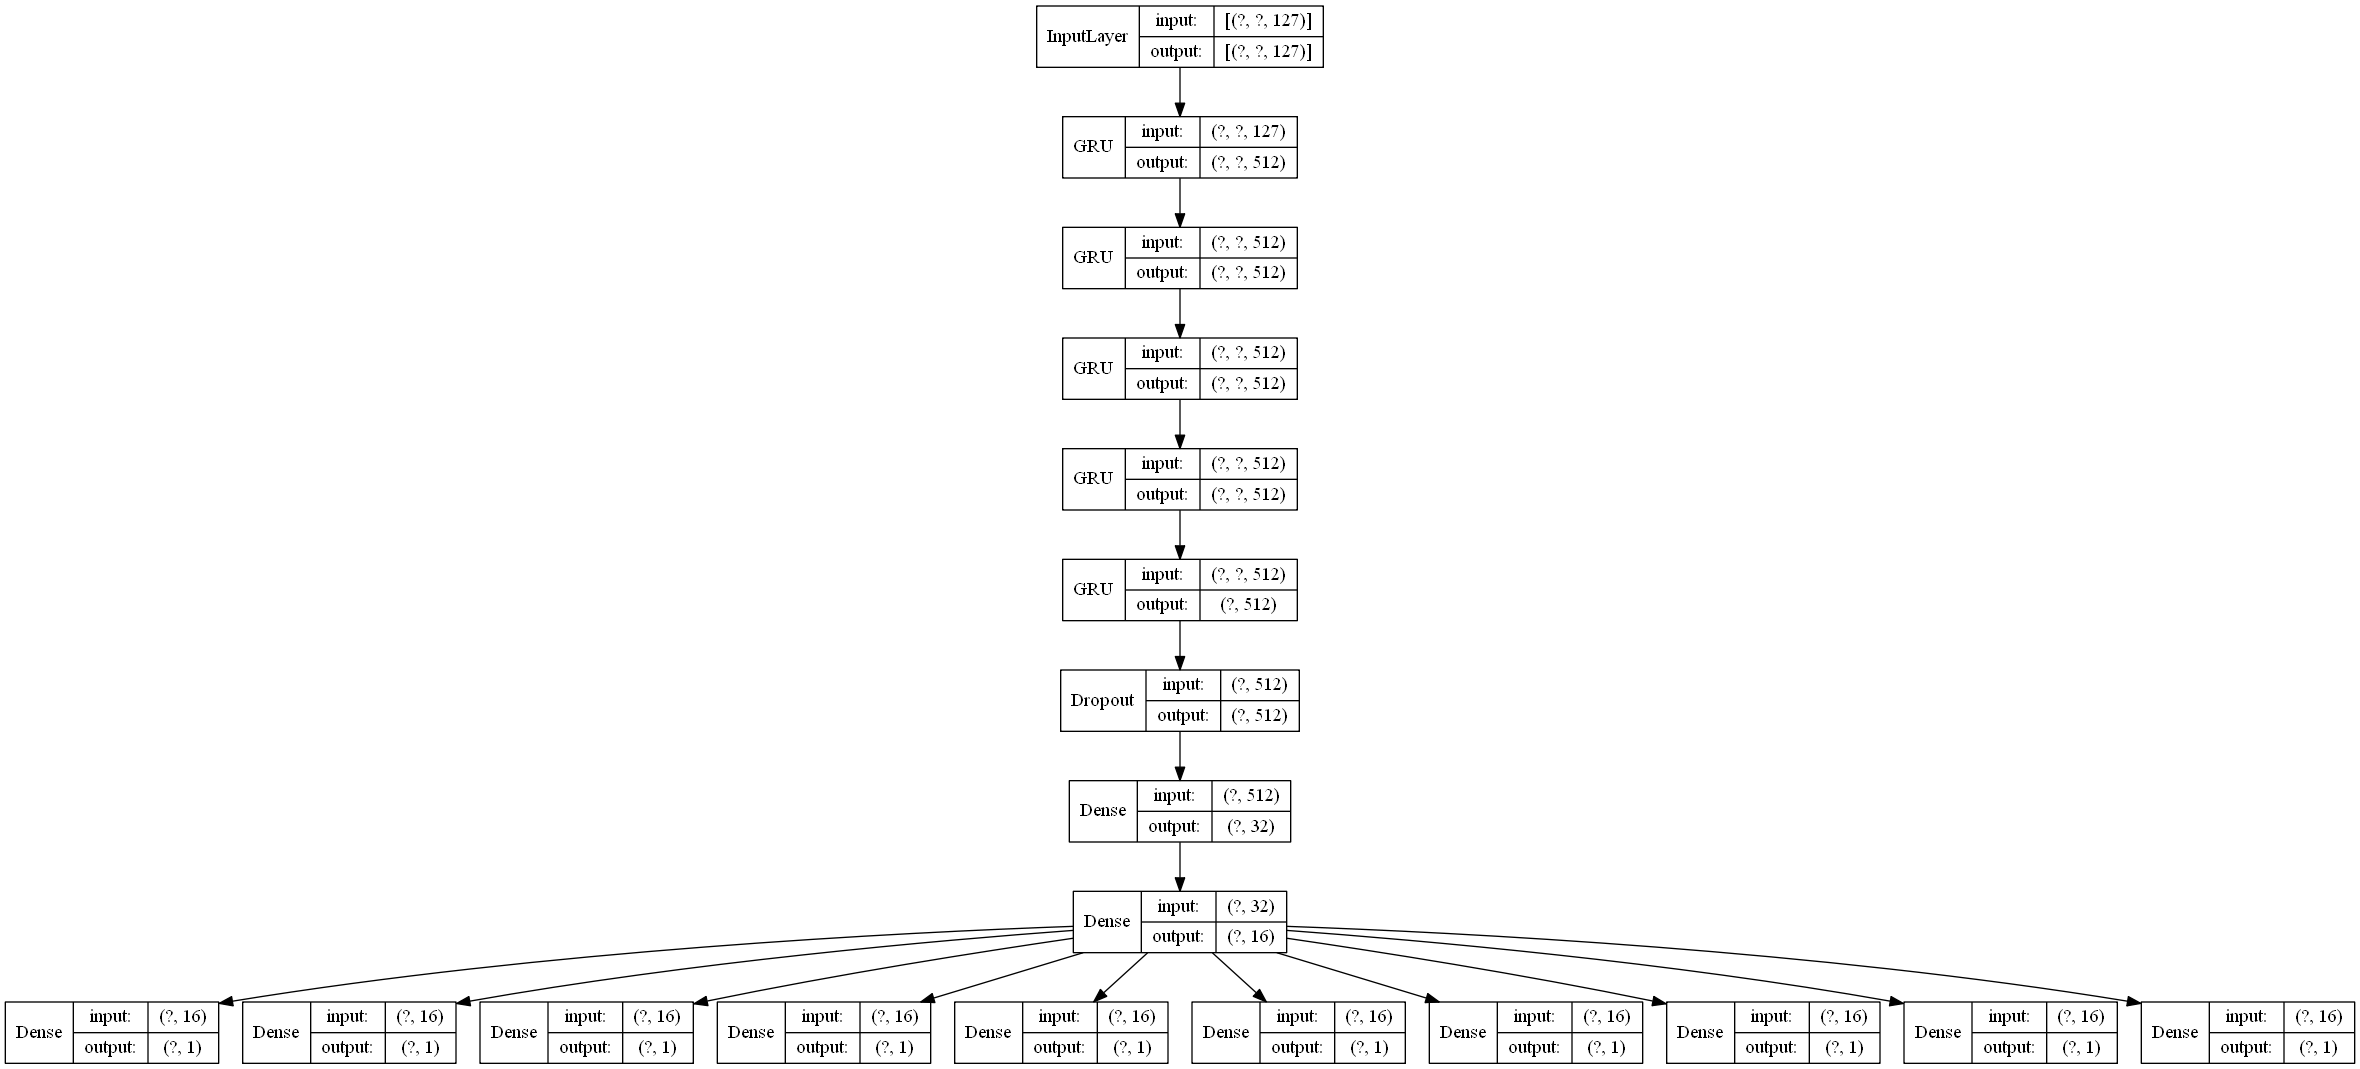

In [16]:
tf.keras.utils.plot_model(model,show_shapes=True, show_layer_names=False)

In [17]:
model.compile(optimizer = Adam(), loss = ['mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse', 
                                          'mse'], metrics=[mse_keras])

In [18]:
history = model.fit(X_train, [y05,
                        y06,
                        y09,
                        y10,
                        y11,
                        y12,
                        y13,
                        y15,
                        y16, 
                        y17], epochs = 150, batch_size= 128)

Train on 4319 samples
Epoch 1/150
4319/4319 [==============================] - 6s 1ms/sample - loss: 1973.4088 - y05_loss: 139.4905 - y06_loss: 113.2224 - y09_loss: 124.1328 - y10_loss: 156.2085 - y11_loss: 245.3481 - y12_loss: 295.6343 - y13_loss: 307.3997 - y15_loss: 140.2481 - y16_loss: 108.0179 - y17_loss: 337.2484 - y05_mse_keras: 139.4652 - y06_mse_keras: 113.2005 - y09_mse_keras: 124.1168 - y10_mse_keras: 156.1912 - y11_mse_keras: 245.3392 - y12_mse_keras: 295.6223 - y13_mse_keras: 307.3975 - y15_mse_keras: 140.2212 - y16_mse_keras: 107.9995 - y17_mse_keras: 337.2336
Epoch 2/150
4319/4319 [==============================] - 1s 199us/sample - loss: 715.4715 - y05_loss: 55.0618 - y06_loss: 52.8908 - y09_loss: 61.9487 - y10_loss: 82.5299 - y11_loss: 126.9035 - y12_loss: 104.5620 - y13_loss: 63.1282 - y15_loss: 58.3484 - y16_loss: 46.5320 - y17_loss: 61.3108 - y05_mse_keras: 55.0286 - y06_mse_keras: 52.8598 - y09_mse_keras: 61.9195 - y10_mse_keras: 82.5057 - y11_mse_keras: 126.8871 -

4319/4319 [==============================] - 1s 222us/sample - loss: 89.3925 - y05_loss: 11.7300 - y06_loss: 12.3565 - y09_loss: 5.5897 - y10_loss: 7.6913 - y11_loss: 10.3894 - y12_loss: 16.6168 - y13_loss: 5.3610 - y15_loss: 5.0963 - y16_loss: 6.1785 - y17_loss: 8.2096 - y05_mse_keras: 11.6248 - y06_mse_keras: 12.2563 - y09_mse_keras: 5.4767 - y10_mse_keras: 7.5857 - y11_mse_keras: 10.2956 - y12_mse_keras: 16.5279 - y13_mse_keras: 5.2484 - y15_mse_keras: 4.9786 - y16_mse_keras: 6.0760 - y17_mse_keras: 8.1054
Epoch 17/150
4319/4319 [==============================] - 1s 210us/sample - loss: 92.8688 - y05_loss: 12.0029 - y06_loss: 12.5256 - y09_loss: 5.8637 - y10_loss: 8.2608 - y11_loss: 10.9022 - y12_loss: 17.0131 - y13_loss: 5.7744 - y15_loss: 5.4919 - y16_loss: 6.6773 - y17_loss: 8.3914 - y05_mse_keras: 11.9071 - y06_mse_keras: 12.4228 - y09_mse_keras: 5.7550 - y10_mse_keras: 8.1588 - y11_mse_keras: 10.8145 - y12_mse_keras: 16.9282 - y13_mse_keras: 5.6554 - y15_mse_keras: 5.3763 - y16

4319/4319 [==============================] - 1s 198us/sample - loss: 69.2079 - y05_loss: 9.7136 - y06_loss: 8.8968 - y09_loss: 4.4603 - y10_loss: 6.1120 - y11_loss: 7.7588 - y12_loss: 12.4316 - y13_loss: 5.0118 - y15_loss: 3.9073 - y16_loss: 4.7188 - y17_loss: 6.0765 - y05_mse_keras: 9.5932 - y06_mse_keras: 8.7821 - y09_mse_keras: 4.3394 - y10_mse_keras: 6.0001 - y11_mse_keras: 7.6511 - y12_mse_keras: 12.3445 - y13_mse_keras: 4.8845 - y15_mse_keras: 3.7736 - y16_mse_keras: 4.5895 - y17_mse_keras: 5.9486
Epoch 32/150
4319/4319 [==============================] - 1s 198us/sample - loss: 62.5394 - y05_loss: 8.9611 - y06_loss: 8.5012 - y09_loss: 3.5561 - y10_loss: 5.3971 - y11_loss: 7.2359 - y12_loss: 12.0548 - y13_loss: 4.3760 - y15_loss: 3.3122 - y16_loss: 3.9298 - y17_loss: 5.2334 - y05_mse_keras: 8.8307 - y06_mse_keras: 8.3779 - y09_mse_keras: 3.4168 - y10_mse_keras: 5.2685 - y11_mse_keras: 7.1248 - y12_mse_keras: 11.9564 - y13_mse_keras: 4.2417 - y15_mse_keras: 3.1641 - y16_mse_keras: 

4319/4319 [==============================] - 1s 196us/sample - loss: 58.4781 - y05_loss: 9.0835 - y06_loss: 7.0994 - y09_loss: 3.9629 - y10_loss: 5.0310 - y11_loss: 7.0982 - y12_loss: 8.6866 - y13_loss: 4.3650 - y15_loss: 3.6097 - y16_loss: 3.9255 - y17_loss: 5.5684 - y05_mse_keras: 8.9629 - y06_mse_keras: 6.9798 - y09_mse_keras: 3.8349 - y10_mse_keras: 4.9138 - y11_mse_keras: 6.9832 - y12_mse_keras: 8.5777 - y13_mse_keras: 4.2429 - y15_mse_keras: 3.4671 - y16_mse_keras: 3.7877 - y17_mse_keras: 5.4457
Epoch 47/150
4319/4319 [==============================] - 1s 197us/sample - loss: 53.1608 - y05_loss: 8.9324 - y06_loss: 6.1690 - y09_loss: 3.7918 - y10_loss: 4.5825 - y11_loss: 6.5525 - y12_loss: 7.2948 - y13_loss: 3.8715 - y15_loss: 3.1670 - y16_loss: 3.5477 - y17_loss: 5.2180 - y05_mse_keras: 8.8121 - y06_mse_keras: 6.0468 - y09_mse_keras: 3.6583 - y10_mse_keras: 4.4432 - y11_mse_keras: 6.4308 - y12_mse_keras: 7.1833 - y13_mse_keras: 3.7298 - y15_mse_keras: 3.0233 - y16_mse_keras: 3.40

4319/4319 [==============================] - 1s 195us/sample - loss: 45.5977 - y05_loss: 8.3559 - y06_loss: 5.0375 - y09_loss: 3.2038 - y10_loss: 3.6166 - y11_loss: 5.8308 - y12_loss: 5.4575 - y13_loss: 3.4486 - y15_loss: 2.8700 - y16_loss: 3.1730 - y17_loss: 4.5340 - y05_mse_keras: 8.2202 - y06_mse_keras: 4.9019 - y09_mse_keras: 3.0596 - y10_mse_keras: 3.4658 - y11_mse_keras: 5.7268 - y12_mse_keras: 5.3254 - y13_mse_keras: 3.3101 - y15_mse_keras: 2.7167 - y16_mse_keras: 3.0207 - y17_mse_keras: 4.3945
Epoch 62/150
4319/4319 [==============================] - 1s 197us/sample - loss: 46.1668 - y05_loss: 8.3530 - y06_loss: 5.2148 - y09_loss: 3.2409 - y10_loss: 3.8332 - y11_loss: 6.1206 - y12_loss: 5.6900 - y13_loss: 3.3639 - y15_loss: 2.7718 - y16_loss: 3.1475 - y17_loss: 4.4589 - y05_mse_keras: 8.2193 - y06_mse_keras: 5.0851 - y09_mse_keras: 3.0954 - y10_mse_keras: 3.6857 - y11_mse_keras: 6.0038 - y12_mse_keras: 5.5650 - y13_mse_keras: 3.2262 - y15_mse_keras: 2.6148 - y16_mse_keras: 2.99

4319/4319 [==============================] - 1s 194us/sample - loss: 43.7467 - y05_loss: 7.9992 - y06_loss: 4.7411 - y09_loss: 3.3043 - y10_loss: 3.6881 - y11_loss: 5.7779 - y12_loss: 4.8809 - y13_loss: 3.1436 - y15_loss: 2.6742 - y16_loss: 3.0223 - y17_loss: 4.5471 - y05_mse_keras: 7.8612 - y06_mse_keras: 4.6049 - y09_mse_keras: 3.1617 - y10_mse_keras: 3.5379 - y11_mse_keras: 5.6608 - y12_mse_keras: 4.7401 - y13_mse_keras: 3.0019 - y15_mse_keras: 2.5166 - y16_mse_keras: 2.8699 - y17_mse_keras: 4.4072
Epoch 76/150
4319/4319 [==============================] - 1s 201us/sample - loss: 45.5804 - y05_loss: 8.2774 - y06_loss: 4.8929 - y09_loss: 3.4786 - y10_loss: 3.8892 - y11_loss: 6.1115 - y12_loss: 5.0368 - y13_loss: 3.1809 - y15_loss: 2.8383 - y16_loss: 3.2173 - y17_loss: 4.6086 - y05_mse_keras: 8.1416 - y06_mse_keras: 4.7606 - y09_mse_keras: 3.3381 - y10_mse_keras: 3.7448 - y11_mse_keras: 6.0019 - y12_mse_keras: 4.8993 - y13_mse_keras: 3.0400 - y15_mse_keras: 2.6760 - y16_mse_keras: 3.06

4319/4319 [==============================] - 1s 229us/sample - loss: 58.6120 - y05_loss: 9.0214 - y06_loss: 6.9721 - y09_loss: 4.3578 - y10_loss: 5.4128 - y11_loss: 7.8224 - y12_loss: 8.0217 - y13_loss: 3.6459 - y15_loss: 3.5623 - y16_loss: 4.1976 - y17_loss: 5.5625 - y05_mse_keras: 8.8969 - y06_mse_keras: 6.8506 - y09_mse_keras: 4.2322 - y10_mse_keras: 5.2861 - y11_mse_keras: 7.7208 - y12_mse_keras: 7.9030 - y13_mse_keras: 3.5189 - y15_mse_keras: 3.4117 - y16_mse_keras: 4.0605 - y17_mse_keras: 5.4256
Epoch 91/150
4319/4319 [==============================] - 1s 222us/sample - loss: 46.5149 - y05_loss: 8.0580 - y06_loss: 4.8652 - y09_loss: 3.4778 - y10_loss: 4.1280 - y11_loss: 5.9963 - y12_loss: 5.5512 - y13_loss: 3.2363 - y15_loss: 2.9840 - y16_loss: 3.3682 - y17_loss: 4.8729 - y05_mse_keras: 7.9214 - y06_mse_keras: 4.7309 - y09_mse_keras: 3.3365 - y10_mse_keras: 3.9938 - y11_mse_keras: 5.8861 - y12_mse_keras: 5.4223 - y13_mse_keras: 3.0933 - y15_mse_keras: 2.8218 - y16_mse_keras: 3.22

4319/4319 [==============================] - 1s 194us/sample - loss: 47.9060 - y05_loss: 7.9104 - y06_loss: 5.0107 - y09_loss: 3.7684 - y10_loss: 4.3392 - y11_loss: 6.4517 - y12_loss: 5.5931 - y13_loss: 3.1030 - y15_loss: 3.1973 - y16_loss: 3.6852 - y17_loss: 4.8016 - y05_mse_keras: 7.7797 - y06_mse_keras: 4.8811 - y09_mse_keras: 3.6386 - y10_mse_keras: 4.2054 - y11_mse_keras: 6.3457 - y12_mse_keras: 5.4624 - y13_mse_keras: 2.9624 - y15_mse_keras: 3.0484 - y16_mse_keras: 3.5447 - y17_mse_keras: 4.6631
Epoch 105/150
4319/4319 [==============================] - 1s 197us/sample - loss: 50.9958 - y05_loss: 8.1788 - y06_loss: 5.5467 - y09_loss: 4.1174 - y10_loss: 4.6177 - y11_loss: 6.7399 - y12_loss: 6.2175 - y13_loss: 3.3301 - y15_loss: 3.3328 - y16_loss: 3.9535 - y17_loss: 5.0341 - y05_mse_keras: 8.0446 - y06_mse_keras: 5.4207 - y09_mse_keras: 3.9835 - y10_mse_keras: 4.4848 - y11_mse_keras: 6.6307 - y12_mse_keras: 6.0932 - y13_mse_keras: 3.1931 - y15_mse_keras: 3.1822 - y16_mse_keras: 3.8

4319/4319 [==============================] - 1s 198us/sample - loss: 37.1109 - y05_loss: 5.8178 - y06_loss: 3.8000 - y09_loss: 3.1277 - y10_loss: 3.3322 - y11_loss: 5.1138 - y12_loss: 4.0393 - y13_loss: 2.5216 - y15_loss: 2.5734 - y16_loss: 2.8866 - y17_loss: 3.8802 - y05_mse_keras: 5.6662 - y06_mse_keras: 3.6503 - y09_mse_keras: 2.9808 - y10_mse_keras: 3.1735 - y11_mse_keras: 4.9966 - y12_mse_keras: 3.8961 - y13_mse_keras: 2.3684 - y15_mse_keras: 2.4076 - y16_mse_keras: 2.7252 - y17_mse_keras: 3.7270
Epoch 120/150
4319/4319 [==============================] - 1s 198us/sample - loss: 41.3682 - y05_loss: 6.6654 - y06_loss: 4.2894 - y09_loss: 3.4002 - y10_loss: 3.6726 - y11_loss: 5.5077 - y12_loss: 4.9217 - y13_loss: 2.6337 - y15_loss: 2.6799 - y16_loss: 3.2011 - y17_loss: 4.3465 - y05_mse_keras: 6.5272 - y06_mse_keras: 4.1455 - y09_mse_keras: 3.2591 - y10_mse_keras: 3.5286 - y11_mse_keras: 5.3954 - y12_mse_keras: 4.7822 - y13_mse_keras: 2.4804 - y15_mse_keras: 2.5252 - y16_mse_keras: 3.0

4319/4319 [==============================] - 1s 194us/sample - loss: 39.9197 - y05_loss: 5.8410 - y06_loss: 3.8984 - y09_loss: 3.5697 - y10_loss: 3.7934 - y11_loss: 5.6487 - y12_loss: 4.5413 - y13_loss: 2.4318 - y15_loss: 2.6722 - y16_loss: 3.4377 - y17_loss: 4.0814 - y05_mse_keras: 5.7013 - y06_mse_keras: 3.7572 - y09_mse_keras: 3.4313 - y10_mse_keras: 3.6536 - y11_mse_keras: 5.5325 - y12_mse_keras: 4.4044 - y13_mse_keras: 2.2731 - y15_mse_keras: 2.5143 - y16_mse_keras: 3.2958 - y17_mse_keras: 3.9359
Epoch 135/150
4319/4319 [==============================] - 1s 198us/sample - loss: 35.5178 - y05_loss: 5.1728 - y06_loss: 3.5603 - y09_loss: 3.1767 - y10_loss: 3.2836 - y11_loss: 4.8603 - y12_loss: 4.0275 - y13_loss: 2.2374 - y15_loss: 2.4271 - y16_loss: 2.9573 - y17_loss: 3.7763 - y05_mse_keras: 5.0283 - y06_mse_keras: 3.4028 - y09_mse_keras: 3.0351 - y10_mse_keras: 3.1321 - y11_mse_keras: 4.7440 - y12_mse_keras: 3.8831 - y13_mse_keras: 2.0806 - y15_mse_keras: 2.2586 - y16_mse_keras: 2.8

4319/4319 [==============================] - 1s 195us/sample - loss: 39.6514 - y05_loss: 5.9579 - y06_loss: 3.8286 - y09_loss: 3.5223 - y10_loss: 3.9110 - y11_loss: 5.3486 - y12_loss: 4.4136 - y13_loss: 2.4962 - y15_loss: 2.8173 - y16_loss: 3.1536 - y17_loss: 4.1898 - y05_mse_keras: 5.8075 - y06_mse_keras: 3.6846 - y09_mse_keras: 3.3876 - y10_mse_keras: 3.7688 - y11_mse_keras: 5.2337 - y12_mse_keras: 4.2748 - y13_mse_keras: 2.3398 - y15_mse_keras: 2.6607 - y16_mse_keras: 3.0057 - y17_mse_keras: 4.0399
Epoch 150/150
4319/4319 [==============================] - 1s 194us/sample - loss: 38.2189 - y05_loss: 5.3332 - y06_loss: 3.6738 - y09_loss: 3.4841 - y10_loss: 3.7593 - y11_loss: 5.3587 - y12_loss: 4.3036 - y13_loss: 2.3036 - y15_loss: 2.7093 - y16_loss: 3.2421 - y17_loss: 4.0382 - y05_mse_keras: 5.1849 - y06_mse_keras: 3.5214 - y09_mse_keras: 3.3370 - y10_mse_keras: 3.6118 - y11_mse_keras: 5.2388 - y12_mse_keras: 4.1637 - y13_mse_keras: 2.1434 - y15_mse_keras: 2.5478 - y16_mse_keras: 3.0

### Transfer Learning

In [19]:
model.layers

In [20]:
pre_layer0 = model.layers[0]
pre_layer1 = model.layers[1]
pre_layer2 = model.layers[2]
pre_layer3 = model.layers[3]
pre_layer4 = model.layers[4]
pre_layer5 = model.layers[5]

In [21]:
pre_layer0.trainable = False
pre_layer1.trainable = False
pre_layer2.trainable = False
pre_layer3.trainable = False
pre_layer4.trainable = False
pre_layer5.trainable = False

In [30]:
pre_layer0(inputs = (None, None, 127))

[(None, None, 127)]

In [53]:
input_x = Input(shape = (None, 127))
x = pre_layer1(input_x)
x = pre_layer2(x)
x = pre_layer3(x)
x = pre_layer4(x)
x = pre_layer5(x)

x = Dropout(0.1)(x)

x = Dense(64,
          activation=ReLU(), kernel_regularizer = regularizers.l2(0.1))(x)
x = Dense(32,
          activation=ReLU(), kernel_regularizer = regularizers.l2(0.1))(x)

out18 = Dense(1, name = 'y18')(x)

In [54]:
model2 = Model(input_x, out18)

In [55]:
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 127)]       0         
_________________________________________________________________
gru (GRU)                    (None, None, 512)         984576    
_________________________________________________________________
gru_1 (GRU)                  (None, None, 512)         1575936   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 512)         1575936   
_________________________________________________________________
gru_3 (GRU)                  (None, None, 512)         1575936   
_________________________________________________________________
gru_4 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0   

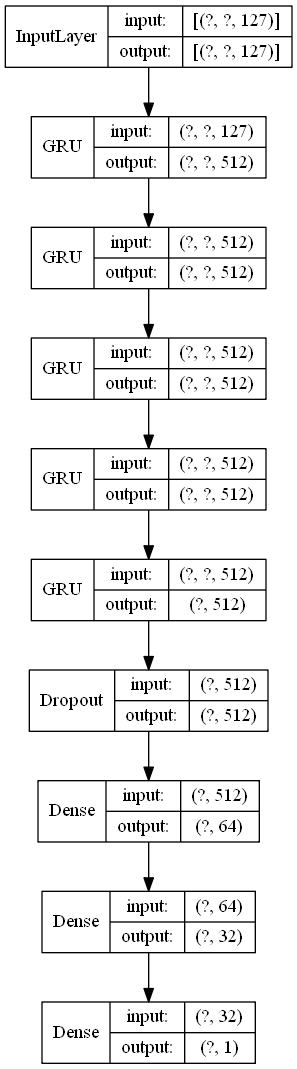

In [56]:
tf.keras.utils.plot_model(model2,show_shapes=True, show_layer_names=False)

In [57]:
model2.compile(optimizer = Adam(), loss = ['mse'], metrics=[mse_keras])

In [58]:
history = model2.fit(X_train2, y18, epochs = 150, batch_size = 16)

Train on 431 samples
Epoch 1/150
431/431 [==============================] - 3s 8ms/sample - loss: 78.4579 - mse_keras: 65.6259
Epoch 2/150
431/431 [==============================] - 0s 618us/sample - loss: 17.4621 - mse_keras: 8.7425
Epoch 3/150
431/431 [==============================] - 0s 619us/sample - loss: 13.3482 - mse_keras: 6.4410
Epoch 4/150
431/431 [==============================] - 0s 620us/sample - loss: 12.6436 - mse_keras: 6.5677
Epoch 5/150
431/431 [==============================] - 0s 625us/sample - loss: 11.6358 - mse_keras: 5.9145
Epoch 6/150
431/431 [==============================] - 0s 621us/sample - loss: 10.7454 - mse_keras: 5.2415
Epoch 7/150
431/431 [==============================] - 0s 631us/sample - loss: 10.4814 - mse_keras: 5.1007
Epoch 8/150
431/431 [==============================] - 0s 609us/sample - loss: 10.2149 - mse_keras: 4.9490
Epoch 9/150
431/431 [==============================] - 0s 635us/sample - loss: 10.5329 - mse_keras: 5.3858
Epoch 10/150
431/

431/431 [==============================] - 0s 642us/sample - loss: 5.7321 - mse_keras: 3.4072
Epoch 78/150
431/431 [==============================] - 0s 627us/sample - loss: 6.0211 - mse_keras: 3.7381
Epoch 79/150
431/431 [==============================] - 0s 654us/sample - loss: 5.6963 - mse_keras: 3.4304
Epoch 80/150
431/431 [==============================] - 0s 643us/sample - loss: 5.2523 - mse_keras: 3.0037
Epoch 81/150
431/431 [==============================] - 0s 617us/sample - loss: 5.3882 - mse_keras: 3.1353
Epoch 82/150
431/431 [==============================] - 0s 619us/sample - loss: 5.3091 - mse_keras: 3.0698
Epoch 83/150
431/431 [==============================] - 0s 638us/sample - loss: 5.1034 - mse_keras: 2.9064
Epoch 84/150
431/431 [==============================] - 0s 614us/sample - loss: 6.1058 - mse_keras: 3.9115
Epoch 85/150
431/431 [==============================] - 0s 648us/sample - loss: 5.3286 - mse_keras: 3.1718
Epoch 86/150
431/431 [============================

In [62]:
#model.save('pre_model.h5')
#model2.save('class_model.h5')

### Make Submission

In [59]:
finetune_pred = model2.predict(X_test)
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':finetune_pred.reshape(1,-1)[0]})
submit.to_csv('submission/2020_4_5_6.csv', index = False, )

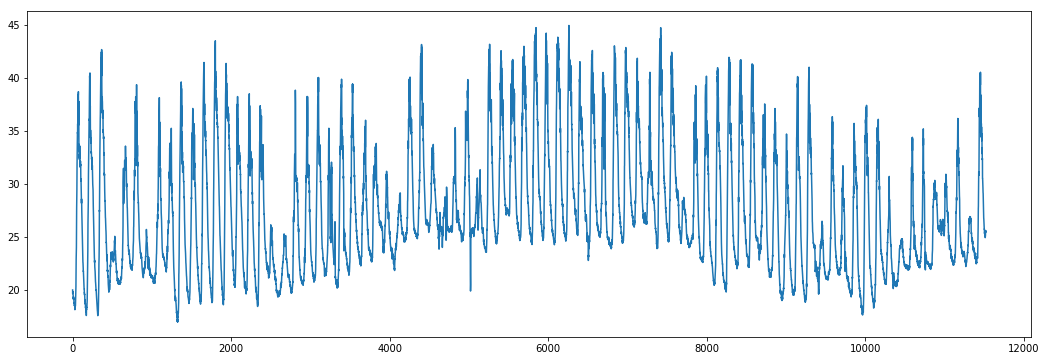

In [60]:
plt.figure(figsize = (18,6))
plt.plot(submit.Y18)

In [61]:
display(submit.query('Y18 > 45'))
display(submit.Y18.min())
display(submit.Y18.max())

,id,Y18


17.032794952392578

44.924312591552734

## End